In [73]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.stats as st

import seaborn as sns
sns.set(font=['IPAmincho'])

## The Vasicek model

In [31]:
#Simulate interest rate oath by the Vasicek model
def vasicek(r0, K, theta, sigma, T=1., N=10, seed=777):
    np.random.seed(seed)
    dt = T/float(N)
    rates = [r0]
    
    for i in range(N):
        dr = K*(theta-rates[-1]*dt) + sigma*np.random.normal()
        rates.append(rates[-1] + dr)
    
    return range(N+1), rates

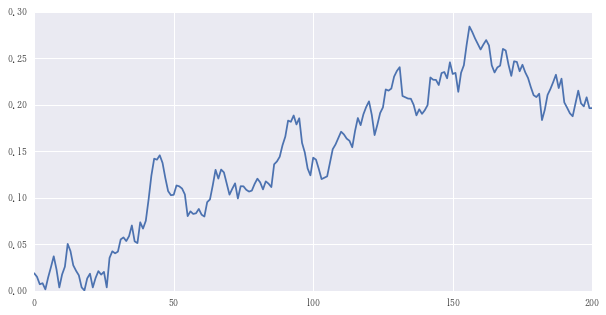

In [59]:
x, y = vasicek(0.01875, 0.20, 0.01, 0.012, 10., 200)
plt.figure(figsize=(10,5))
plt.plot(x, y)

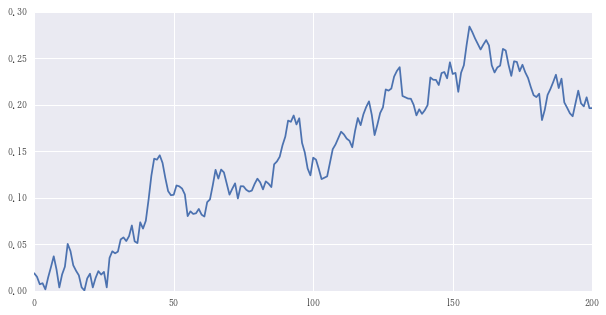

In [60]:
x, y = vasicek(0.01875, 0.20, 0.01, 0.012, 10., 200)
plt.figure(figsize=(10,5))
plt.plot(x, y)

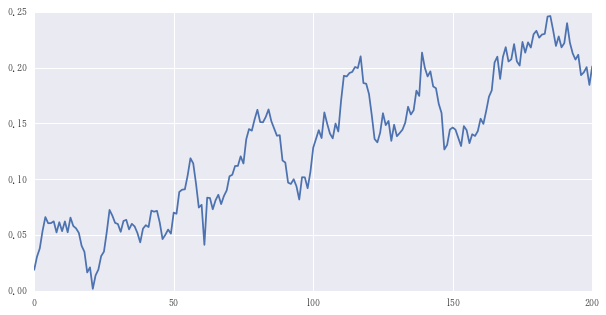

In [61]:
x, y = vasicek(0.01875, 0.20, 0.01, 0.012, 10., 200, seed=666)
plt.figure(figsize=(10,5))
plt.plot(x, y)

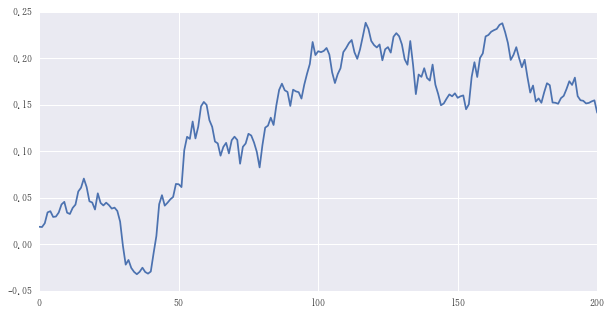

In [62]:
x, y = vasicek(0.01875, 0.20, 0.01, 0.012, 10., 200, seed=888)
plt.figure(figsize=(10,5))
plt.plot(x, y)

## Pricing a zero-coupon bond by the Vasicek model

In [63]:
# Get zero coupon bond price by Vasicek model
def exact_zcb(theta, kappa, sigma, tau, r0=0.):
    B = (1 - np.exp(-kappa*tau))/kappa
    A = np.exp((theta - (sigma**2)/(2*(kappa**2)))*(B - tau) - (sigma**2)/(4*kappa)*(B**2))
    return A*np.exp(-r0*B)

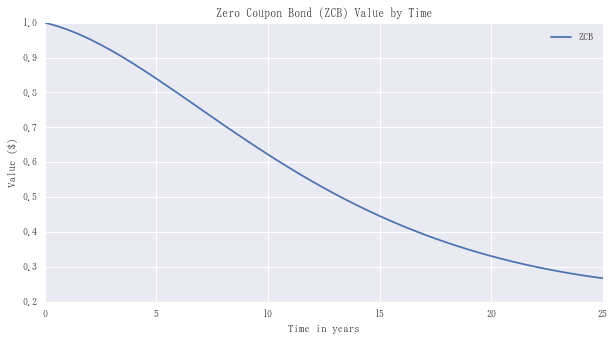

In [64]:
Ts = np.r_[0.0:25.5:0.5]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

plt.figure(figsize=(10,5))
plt.title("Zero Coupon Bond (ZCB) Value by Time")
plt.plot(Ts, zcbs, label='ZCB')
plt.ylabel("Value ($)")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)
plt.show()

## Value of early-exercise

In [65]:
def exercise_value(K, R, t):
    return K*math.exp(-R*t)

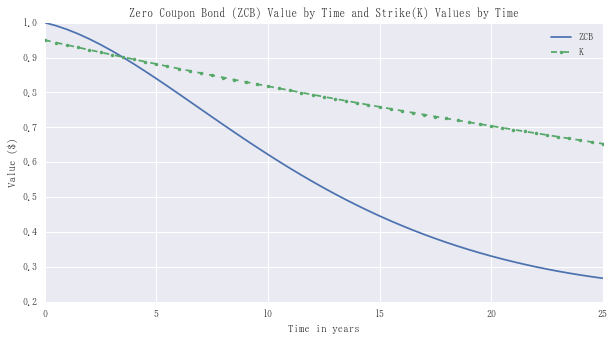

In [72]:
Ts = np.r_[0.0:25.5:0.5]
Ks = [exercise_value(0.95, 0.015, t) for t in Ts]
zcbs = [exact_zcb(0.5, 0.02, 0.03, t, 0.015) for t in Ts]

plt.figure(figsize=(10,5))
plt.title("Zero Coupon Bond (ZCB) Value by Time "
          "and Strike(K) Values by Time")
plt.plot(Ts, zcbs, label='ZCB')
plt.plot(Ts, Ks, label='K', linestyle="--", marker=".")
plt.ylabel("Value ($)")
plt.xlabel("Time in years")
plt.legend()
plt.grid(True)
plt.show()

債券の発行者はコールを行使する権利を保有しているので、コール付きゼロクーポン債券の価格は、
$$callable~zero~coupon~bond~price~=~min(ZCB, K)$$
となる。  
この債券価格は現在の金利の水準が与えられた時の近似である。  
次のステップとして、policy iterationの形で、早期行使を考慮することが考えられる。

## Policy iteration by finite differences

In [84]:
class VasicekCZCB:
    def __init__(self):
        self.norminv = st.distributions.norm.ppf
        self.nor = st.distributions.norm.cdf
        
    def vasicek_czcb_values(self, r0, R, ratio, T, sigma, kappa, theta, M, prob=1e-6, max_policy_iter=10,
                            grid_struct_const=0.25, rs=None):
        r_min, dr, N, dtau = self.vasicek_params(r0, M, sigma, kappa, theta, T, prob, grid_struct_const, rs)
        r = np.r_[0:N]*dr + r_min
        v_mplus1 = np.ones(N)
        
        for i in range(1, M+1):
            K = self.exercise_call_price(R, ratio, i*dtau)
            eex = np.ones(N)*K
            subdiagonal, diagonal, superdiagonal = self.vasicek_diagonals(sigma, kappa, theta, r_min, dr, N, dtau)
            v_mplus1, iterations = self.iterate(subdiagonal, diagonal, superdiagonal, v_mplus1, eex, max_policy_iter)
        return r, v_mplus1

    def vasicek_params(self, r0, M, sigma, kappa, theta, T, prob, grid_struct_const=0.25, rs=None):
        (r_min, r_max) = (rs[0], rs[-1]) if not rs is None else self.vasicek_limits(r0, sigma, kappa, theta, T, prob)
        dt = T/float(M)
        N = self.calculate_N(grid_struct_const, dt,
                             sigma, r_max, r_min)
        dr = (r_max-r_min)/(N-1)
        return r_min, dr, N, dt

    def calculate_N(self, max_structure_const, dt,
                    sigma, r_max, r_min):
        N = 0
        while True:
            N += 1
            grid_structure_interval = dt*(sigma**2)/(
                ((r_max-r_min)/float(N))**2)
            if grid_structure_interval > max_structure_const:
                break

        return N

    def vasicek_limits(self, r0, sigma, kappa,
                       theta, T, prob=1e-6):
        er = theta+(r0-theta)*math.exp(-kappa*T)
        variance = (sigma**2)*T if kappa==0 else (sigma**2)/(2*kappa)*(1-math.exp(-2*kappa*T))
        stdev = math.sqrt(variance)
        r_min = self.norminv(prob, er, stdev)
        r_max = self.norminv(1-prob, er, stdev)
        return r_min, r_max

    def vasicek_diagonals(self, sigma, kappa, theta,
                          r_min, dr, N, dtau):
        rn = np.r_[0:N]*dr + r_min
        subdiagonals = kappa*(theta-rn)*dtau/(2*dr) - 0.5*(sigma**2)*dtau/(dr**2)
        diagonals = 1 + rn*dtau + sigma**2*dtau/(dr**2)
        superdiagonals = -kappa*(theta-rn)*dtau/(2*dr) - 0.5*(sigma**2)*dtau/(dr**2)

        # Implement boundary conditions.
        if N > 0:
            v_subd0 = subdiagonals[0]
            superdiagonals[0] = superdiagonals[0] - subdiagonals[0]
            diagonals[0] += 2*v_subd0
            subdiagonals[0] = 0

        if N > 1:
            v_superd_last = superdiagonals[-1]
            superdiagonals[-1] = superdiagonals[-1] - subdiagonals[-1]
            diagonals[-1] += 2*v_superd_last
            superdiagonals[-1] = 0

        return subdiagonals, diagonals, superdiagonals

    def check_exercise(self, V, eex):
        return V > eex

    def exercise_call_price(self, R, ratio, tau):
        K = ratio*np.exp(-R*tau)
        return K

    def vasicek_policy_diagonals(self, subdiagonal, diagonal,
                                 superdiagonal, v_old, v_new,
                                 eex):
        has_early_exercise = self.check_exercise(v_new, eex)
        subdiagonal[has_early_exercise] = 0
        superdiagonal[has_early_exercise] = 0
        policy = v_old/eex
        policy_values = policy[has_early_exercise]
        diagonal[has_early_exercise] = policy_values
        return subdiagonal, diagonal, superdiagonal

    def iterate(self, subdiagonal, diagonal, superdiagonal,
                v_old, eex, max_policy_iter=10):
        v_mplus1 = v_old
        v_m = v_old
        change = np.zeros(len(v_old))
        prev_changes = np.zeros(len(v_old))

        iterations = 0
        while iterations <= max_policy_iter:
            iterations += 1

            v_mplus1 = self.tridiagonal_solve(subdiagonal, diagonal, superdiagonal, v_old)
            subdiagonal, diagonal, superdiagonal = self.vasicek_policy_diagonals(subdiagonal, diagonal, superdiagonal,
                                              v_old, v_mplus1, eex)

            is_eex = self.check_exercise(v_mplus1, eex)
            change[is_eex] = 1

            if iterations > 1:
                change[v_mplus1 != v_m] = 1

            is_no_more_eex = False if True in is_eex else True
            if is_no_more_eex:
                break

            v_mplus1[is_eex] = eex[is_eex]
            changes = (change == prev_changes)

            is_no_further_changes = all((x == 1) for x in changes)
            if is_no_further_changes:
                break

            prev_changes = change
            v_m = v_mplus1

        return v_mplus1, (iterations-1)

    def tridiagonal_solve(self, a, b, c, d):
        nf = len(a)  # Number of equations
        ac, bc, cc, dc = map(np.array, (a, b, c, d))  # Copy the array
        for it in range(1, nf):
            mc = ac[it]/bc[it-1]
            bc[it] = bc[it] - mc*cc[it-1] 
            dc[it] = dc[it] - mc*dc[it-1]

        xc = ac
        xc[-1] = dc[-1]/bc[-1]

        for il in range(nf-2, -1, -1):
            xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

        del bc, cc, dc  # Delete variables from memory

        return xc        

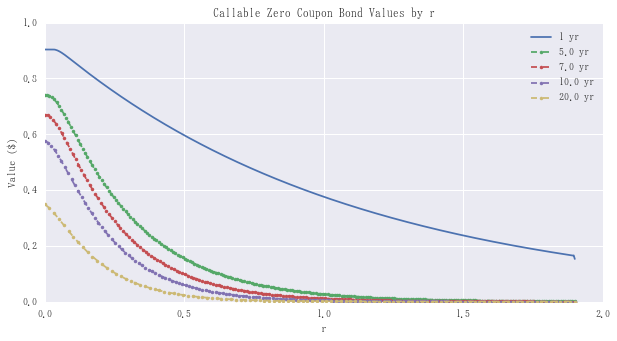

In [85]:
r0 = 0.05
R = 0.05
ratio = 0.95
sigma = 0.03
kappa = 0.15
theta = 0.05
prob = 1e-6
M = 250
max_policy_iter=10
grid_struct_interval = 0.25
rs = np.r_[0.0:2.0:0.1]

Vasicek = VasicekCZCB()
r, vals = Vasicek.vasicek_czcb_values(r0, R, ratio, 1., sigma, kappa, theta, M, prob,
                                      max_policy_iter, grid_struct_interval, rs)

plt.figure(figsize=(10,5))
plt.title("Callable Zero Coupon Bond Values by r")
plt.plot(r, vals, label='1 yr')

for T in [5., 7., 10., 20.]:
    r, vals = Vasicek.vasicek_czcb_values(r0, R, ratio, T, sigma, kappa, theta, M, prob, 
                                          max_policy_iter, grid_struct_interval, rs)
    plt.plot(r, vals, label=str(T)+' yr', linestyle="--", marker=".")

plt.ylabel("Value ($)")
plt.xlabel("r")
plt.legend()
plt.grid(True)
plt.show()

In [83]:
for i in range(5, -1, -1):
    print(i)

5
4
3
2
1
0
